# Imports

In [ ]:
# google colab installs

!pip install condacolab &> /dev/null
import condacolab
condacolab.install()

# install all packages in one call (+ use mamba instead of conda)
!mamba install xarray-datatree intake-esm gcsfs xmip aiohttp cartopy nc-time-axis cf_xarray xarrayutils "esmf<=8.3.1" xesmf &> /dev/null

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:18
🔁 Restarting kernel...


In [ ]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# # properly install cartopy in colab to avoid session crash
!apt-get install libproj-dev proj-data proj-bin --quiet
!apt-get install libgeos-dev --quiet
!pip install cython --quiet
!pip install cartopy --quiet
!pip install geoviews

!apt-get -qq install python-cartopy python3-cartopy  --quiet
!pip uninstall -y shapely  --quiet
!pip install shapely --no-binary shapely  --quiet

!pip install boto3 --quiet

# you may need to restart the runtime after running this cell and that is ok

Reading package lists...
Building dependency tree...
Reading state information...
libproj-dev is already the newest version (8.2.1-1).
libproj-dev set to manually installed.
proj-data is already the newest version (8.2.1-1).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 154 kB of archives.
After this operation, 492 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 proj-bin amd64 8.2.1-1 [154 kB]
Fetched 154 kB in 3s (58.9 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 120895 files and directories currently installed.)
Preparing to unpack .../proj-bin_8.2.1-1_amd64.deb ...
Unpacking proj-bin (8.2.1-1) ...
Setting up proj-bin (8.2.1-1) ...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is alre

In [ ]:
!pip install pydantic==2.3

In [ ]:
# imports

import time

tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import xesmf as xe
from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot
from datatree import DataTree
from xmip.postprocessing import _parse_metric
import cartopy.crs as ccrs
import pooch
import os
import tempfile
from scipy import stats

In [ ]:
# functions

%matplotlib inline

col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data


def load_cmip6(source_id, variable_id, member_id, table_id):  # load selected model
    cat = col.search(
        source_id=source_ids,
        variable_id=variable_id,
        member_id=member_id,
        table_id=table_id,
        grid_label="gn",
        experiment_id=[
            "historical",
            "ssp126",
            "ssp245",
            "ssp585",
        ],  # downloading the scenarios out of the total 5+historical
        require_all_on=["source_id"],
    )

    kwargs = dict(
        preprocess=combined_preprocessing,
        xarray_open_kwargs=dict(use_cftime=True),
        storage_options={"token": "anon"},
    )
    cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
    dt = cat.to_datatree(**kwargs)

    return dt

/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


In [ ]:
import pydantic
pydantic.__version__

'2.3.0'

In [ ]:
# helper functions

def pooch_load(filelocation=None,filename=None,processor=None):
    shared_location='/home/jovyan/shared/Data/Projects/ENSO' # this is different for each day
    user_temp_cache=tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location,filename)):
        file = os.path.join(shared_location,filename)
    else:
        file = pooch.retrieve(filelocation,known_hash=None,fname=os.path.join(user_temp_cache,filename),processor=processor)

    return file

# NOAA Data
- SST
- Precipitation
- Anomalies

In [ ]:
# Ocean surface temprature
filename_SST='sst.mnmean.nc'
url_SST = 'https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc'

do_sst = xr.open_dataset(pooch_load(url_SST,filename_SST), drop_variables=['time_bnds'])

# Precipitation rate (notice the units in the plot below)
filename_prec_rate='precip.mon.mean.nc'
url_prec_rate='https://downloads.psl.noaa.gov/Datasets/cmap/enh/precip.mon.mean.nc'
do_pr = xr.open_dataset(pooch_load(url_prec_rate,filename_prec_rate))

# Air Temperature Anomalies
filename_tas='air.2x2.1200.mon.anom.comb.nc'
url_tas='https://downloads.psl.noaa.gov/Datasets/gistemp/combined/1200km/air.2x2.1200.mon.anom.comb.nc'
do_tas = xr.open_dataset(pooch_load(url_tas,filename_tas))

SHA256 hash of downloaded file: 94b6b7236e2cb54118ac2ba1dc10ba3f06850fd3a680e089d48ed22d353d0500
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 0224151adc706cfcf88b6be5739a4d380b821e448da02ff732bb59182941cc5b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.
SHA256 hash of downloaded file: 7c7bcc5200abb60fd9ed57c1a446590fc988eecd704aa3a9c224d33b39a37f62
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [ ]:
## Coordinates Indonesia

x_ind = slice(95, 141) # longitude
y_ind = slice(7,-12) # latitude

In [ ]:
## Precipitation data for Indonesia
do_pr.precip

<xarray.DataArray 'precip' (time: 535, lat: 72, lon: 144)>
[5546880 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-07-01
Attributes:
    long_name:     Average Monthly Rate of Precipitation
    valid_range:   [ 0. 70.]
    units:         mm/day
    precision:     2
    var_desc:      Precipitation
    dataset:       CPC Merged Analysis of Precipitation Enhanced
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    actual_range:  [   0.   1170.24]

In [ ]:
print(do_pr.precip)

<xarray.DataArray 'precip' (time: 535, lat: 72, lon: 144)>
[5546880 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 88.75 86.25 83.75 81.25 ... -83.75 -86.25 -88.75
  * lon      (lon) float32 1.25 3.75 6.25 8.75 11.25 ... 351.2 353.8 356.2 358.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-07-01
Attributes:
    long_name:     Average Monthly Rate of Precipitation
    valid_range:   [ 0. 70.]
    units:         mm/day
    precision:     2
    var_desc:      Precipitation
    dataset:       CPC Merged Analysis of Precipitation Enhanced
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    actual_range:  [   0.   1170.24]


In [ ]:
print(do_pr.precip.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind))

<xarray.DataArray 'precip' (time: 535, lat: 8, lon: 18)>
[77040 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 6.25 3.75 1.25 -1.25 -3.75 -6.25 -8.75 -11.25
  * lon      (lon) float32 96.25 98.75 101.2 103.8 ... 131.2 133.8 136.2 138.8
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-07-01
Attributes:
    long_name:     Average Monthly Rate of Precipitation
    valid_range:   [ 0. 70.]
    units:         mm/day
    precision:     2
    var_desc:      Precipitation
    dataset:       CPC Merged Analysis of Precipitation Enhanced
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Mean
    actual_range:  [   0.   1170.24]


In [ ]:
rain = do_pr.precip.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)

In [ ]:
rain.shape

(535, 8, 18)

In [ ]:
## Data time span available
12*(2023-1979)+7

535

In [ ]:
## SST data for Indonesia
do_sst

In [ ]:
print(do_sst.sst)

In [ ]:
print(do_sst.sst.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind))

<xarray.DataArray 'sst' (time: 535, lat: 10, lon: 23)>
[123050 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 6.0 4.0 2.0 0.0 -2.0 -4.0 -6.0 -8.0 -10.0 -12.0
  * lon      (lon) float32 96.0 98.0 100.0 102.0 ... 134.0 136.0 138.0 140.0
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2023-07-01
Attributes:
    long_name:     Monthly Means of Sea Surface Temperature
    units:         degC
    var_desc:      Sea Surface Temperature
    level_desc:    Surface
    statistic:     Mean
    dataset:       NOAA Extended Reconstructed SST V5
    parent_stat:   Individual Values
    actual_range:  [-1.8     42.32636]
    valid_range:   [-1.8 45. ]


In [ ]:
sst = do_sst.sst.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)

In [ ]:
## Air temperature anomalies data for Indonesia
do_tas

In [ ]:
print(do_tas.air)

In [ ]:
print(do_tas.air.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind))

In [ ]:
temp = do_tas.air.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)

### Plots

In [ ]:
## Plot data
plt.title('Air Temperature anomaly')
temp.sel(time="1979-07-01").plot()
plt.show()

plt.title('Air Temperature anomaly')
temp.sel(time="2001-07-01").plot()
plt.show()

plt.title('Air Temperature anomaly')
temp.sel(time="2023-07-01").plot()


In [ ]:
## Plot data
plt.title('SST Temperature')
sst.sel(time="1979-07-01").plot()
plt.show()

plt.title('SST Temperature')
sst.sel(time="2001-07-01").plot()
plt.show()

plt.title('SST Temperature')
sst.sel(time="2023-07-01").plot()


In [ ]:
## Plot data
plt.title('Precipitation')
rain.sel(time="1979-07-01").plot()
plt.show()

plt.title('Precipitation')
rain.sel(time="2001-07-01").plot()
plt.show()

plt.title('Precipitation')
rain.sel(time="2023-07-01").plot()


Maps plots

In [ ]:
## Air temperature anomalies

air_ind_last = do_tas.air.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)[-1,:,:].squeeze()
air_ind_mid = do_tas.air.sel(time=slice('2021-07-01','2021-08-01'), lat=y_ind, lon=x_ind)[0,:,:].squeeze()
air_ind_firs = do_tas.air.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)[6,:,:].squeeze()

In [ ]:
fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
air_ind_firs.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=air_ind_firs.min().compute(),
    vmax=air_ind_firs.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

air_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=air_ind_mid.min().compute(),
    vmax=air_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

air_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=air_ind_last.min().compute(),
    vmax=air_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[2].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

In [ ]:
## SST temperature

sst_ind_last = do_sst.sst.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)[-1,:,:].squeeze()
sst_ind_mid = do_sst.sst.sel(time=slice('2021-07-01','2021-08-01'), lat=y_ind, lon=x_ind)[0,:,:].squeeze()
sst_ind_firs = do_sst.sst.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)[6,:,:].squeeze()

In [ ]:
fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
sst_ind_firs.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=sst_ind_firs.min().compute(),
    vmax=sst_ind_firs.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

sst_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=sst_ind_mid.min().compute(),
    vmax=sst_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

sst_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=sst_ind_last.min().compute(),
    vmax=sst_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[2].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

In [ ]:
## precipitation

pr_ind_last = do_pr.precip.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)[-1,:,:].squeeze()
pr_ind_mid = do_pr.precip.sel(time=slice('2021-07-01','2021-08-01'), lat=y_ind, lon=x_ind)[0,:,:].squeeze()
pr_ind_firs = do_pr.precip.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)[6,:,:].squeeze()

In [ ]:
fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
pr_ind_firs.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=pr_ind_firs.min().compute(),
    vmax=pr_ind_firs.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

pr_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=pr_ind_mid.min().compute(),
    vmax=pr_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

pr_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=pr_ind_last.min().compute(),
    vmax=pr_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[2].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

#### Correlation

In [ ]:
## precipitation

rain_timeseries = do_pr.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)
rain_timeseries = rain_timeseries.mean(["lon", "lat"], keep_attrs=True)



In [ ]:
rain_timeseries

In [ ]:
#property_timeseries_mean = property_timeseries.groupby("time.year.month")
#property_timeseries_mean = property_timeseries.mean(dim=time)
rain_timeseries_mean = np.array(rain_timeseries.precip)
#print(property_timeseries.precip)

In [ ]:
len(rain_timeseries_mean)

535

In [ ]:
## Air temperature anomalies

tas_timeseries = do_tas.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)
tas_timeseries = tas_timeseries.mean(["lon", "lat"], keep_attrs=True)
tas_timeseries_mean = np.array(tas_timeseries.air)

In [ ]:
len(tas_timeseries_mean)

535

In [ ]:
## SST

sst_timeseries = do_sst.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)
sst_timeseries = sst_timeseries.mean(["lon", "lat"], keep_attrs=True)
sst_timeseries_mean = np.array(sst_timeseries.sst)

In [ ]:
len(sst_timeseries_mean)

535

In [ ]:
np.isnan(tas_timeseries_mean).sum()

0

In [ ]:
np.isnan(sst_timeseries_mean).sum()

0

In [ ]:
np.isnan(rain_timeseries_mean).sum()

0

In [ ]:
var = [tas_timeseries_mean, sst_timeseries_mean]
names = ['tas', 'sst']

In [ ]:
for i,n in zip(var, names):
    print(n)
    print(np.cov(i, rain_timeseries_mean))
    print()

tas
[[0.09737103 0.05606734]
 [0.05606734 4.25327859]]

sst
[[0.2842877  0.46579388]
 [0.46579388 4.25327859]]



# NOAA Dataset
- NDVI

In [ ]:
pip install s3fs

In [ ]:
# pip install cartopy

In [ ]:
# pip install boto3

In [ ]:
# # imports
# import s3fs
# import xarray as xr
# import matplotlib.pyplot as plt
# import cartopy
# import cartopy.crs as ccrs
# import boto3
# import botocore
# import pooch
# import os
# import tempfile

In [ ]:
# # connect to the AWS S3 bucket for the GPCP Monthly Precipitation CDR data
# fs = s3fs.S3FileSystem(anon=True)

# # get the list of all data files in the AWS S3 bucket fit the data file pattern.
# file_pattern = "noaa-cdr-ndvi-pds/data/*/AVHRR-Land_v005_AVH13C1_NOAA-*_*01_*.nc" # this only collects up to 2013
# file_location = fs.glob(file_pattern)

In [ ]:
# file_location

In [ ]:
# filelocation="http://s3.amazonaws.com/" + file_location[0]
# filelocation

'http://s3.amazonaws.com/noaa-cdr-ndvi-pds/data/1981/AVHRR-Land_v005_AVH13C1_NOAA-07_19810701_c20170609165932.nc'

In [ ]:
# filename=file_location[0]
# filename

'noaa-cdr-ndvi-pds/data/1981/AVHRR-Land_v005_AVH13C1_NOAA-07_19810701_c20170609165932.nc'

In [ ]:
# # first, open a client connection
# client = boto3.client(
#     "s3", config=botocore.client.Config(signature_version=botocore.UNSIGNED)
# )  # initialize aws s3 bucket client

# # read single data file to understand the file structure
# ds_unique = xr.open_dataset(pooch.retrieve('http://s3.amazonaws.com/'+file_location[0],known_hash=None )) # open the file
# #ds_single = xr.open_dataset(
# #    pooch_load(
# #        filelocation="http://s3.amazonaws.com/" + file_location[0],
# #        filename=file_location[0],
# #    )
# #)
# # check how many variables are inluded in one data file
# ds_unique.data_vars
# ds_unique.coords

In [ ]:
# # open all the monthly data files for all timespans
# # this process will take ~ 5 minute to complete due to the number of data files.

# file_ob = [pooch.retrieve('http://s3.amazonaws.com/'+file,known_hash=None ) for file in file_location]
# #file_ob = [
# #    pooch_load(filelocation="http://s3.amazonaws.com/" + file, filename=file)
# #    for file in file_location
# #]

In [ ]:
# # connect to the AWS S3 bucket
# fs = s3fs.S3FileSystem(anon=True)

# # get the list of all data files in the AWS S3 bucket fit the data file pattern.
# file_pattern2 = "noaa-cdr-ndvi-pds/data/*/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_*01_*.nc" # this collects from 2014 onwards
# file_location2 = fs.glob(file_pattern2)

In [ ]:
# filelocation2="http://s3.amazonaws.com/" + file_location2[0]
# filelocation2

'http://s3.amazonaws.com/noaa-cdr-ndvi-pds/data/2014/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20140101_c20220415172712.nc'

In [ ]:
# filename2=file_location2[0]
# filename2

'noaa-cdr-ndvi-pds/data/2014/VIIRS-Land_v001-preliminary_NPP13C1_S-NPP_20140101_c20220415172712.nc'

In [ ]:
# # first, open a client connection
# client = boto3.client(
#     "s3", config=botocore.client.Config(signature_version=botocore.UNSIGNED)
# )  # initialize aws s3 bucket client

# # read single data file to understand the file structure
# ds_unique2 = xr.open_dataset(pooch.retrieve('http://s3.amazonaws.com/'+file_location2[0],known_hash=None )) # open the file


In [ ]:
# # open all the monthly data files for all timespans
# # this process will take ~ 5 minute to complete due to the number of data files.

# file_ob2 = [pooch.retrieve('http://s3.amazonaws.com/'+file,known_hash=None ) for file in file_location2]
# #file_ob = [
# #    pooch_load(filelocation="http://s3.amazonaws.com/" + file, filename=file)
# #    for file in file_location
# #]

In [ ]:
# # using this function instead of 'open_dataset' will concatenate the data along the dimension we specify
# ds = xr.open_mfdataset((file_ob,file_ob2) combine="nested", concat_dim="time")

# # comment for colab users only: this could toss an error message for you.
# # you should still be able to use the dataset with this error just not print ds
# # you can try uncommenting the following line to avoid the error
# # ds.attrs['history']='' # the history attribute have unique chars that cause a crash on Google colab.
# ds.attrs

In [ ]:
# ds.NDVI

# CMIP6 Dataset

In [ ]:
# functions

%matplotlib inline

col = intake.open_esm_datastore(
    "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
)  # open an intake catalog containing the Pangeo CMIP cloud data


def load_cmip6(source_id, variable_id, member_id, table_id):  # load selected model
    cat = col.search(
        source_id=source_ids,
        variable_id=variable_id,
        member_id=member_id,
        table_id=table_id,
        grid_label="gn",
        experiment_id=[
            "historical",
            "ssp126",
            "ssp245",
            "ssp585",
        ],  # downloading the scenarios out of the total 5+historical
        require_all_on=["source_id"],
    )

    kwargs = dict(
        preprocess=combined_preprocessing,
        xarray_open_kwargs=dict(use_cftime=True),
        storage_options={"token": "anon"},
    )
    cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
    dt = cat.to_datatree(**kwargs)

    return dt

/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


In [ ]:
cat = col.search(
    source_id="GFDL-ESM4",
    variable_id=[
        "gpp",
        "npp",
        "nbp",
        "treeFrac",
        "grassFrac",
        "cropFrac",
        "pastureFrac",
    ],  # No 'shrubFrac','baresoilFrac','residualFrac' in GFDL-ESM4
    member_id="r1i1p1f1",
    table_id="Lmon", #["Oclim", "Amon", "Omon", "Lmon", "Limon", "Oimon", "Aero", "cfMon"]
    grid_label="gr1",
    experiment_id=["historical"],
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


In [ ]:
# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_Lmon_variables = cat.to_datatree(**kwargs)

# convert to dataset instead of datatree, remove extra singleton dimensions
ds_Lmon = dt_Lmon_variables["GFDL-ESM4"]["historical"].to_dataset().squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


In [ ]:
# get monthly 'extension' variables

# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id="GFDL-ESM4",
    variable_id="nep",
    member_id="r1i1p1f1",
    table_id="Emon",
    grid_label="gr1",
    experiment_id=["historical"],
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_Emon_variables = cat.to_datatree(**kwargs)

# convert to dataset instead of datatree, remove extra singleton dimensions
ds_Emon = dt_Emon_variables["GFDL-ESM4"]["historical"].to_dataset().squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


In [ ]:
# get atmospheric variables

# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id="GFDL-ESM4",
    variable_id=["rsds", "rsus", "tas", "pr"],
    member_id="r1i1p1f1",
    table_id="Amon",
    grid_label="gr1",
    experiment_id=["historical"],
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_Amon_variables = cat.to_datatree(**kwargs)

# convert to dataset instead of datatree, remove extra singleton dimensions
ds_Amon = dt_Amon_variables["GFDL-ESM4"]["historical"].to_dataset().squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


In [ ]:
# get atmospheric variables

# from the full `col` object, create a subset using facet search
cat = col.search(
    source_id="GFDL-ESM4",
    variable_id=["areacella"],
    member_id="r1i1p1f1",
    table_id="fx",
    grid_label="gr1",
    experiment_id=["historical"],
    require_all_on=[
        "source_id"
    ],  # make sure that we only get models which have all of the above experiments
)

# convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
kwargs = dict(
    preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
    xarray_open_kwargs=dict(
        use_cftime=True
    ),  # ensure all datasets use the same time index
    storage_options={
        "token": "anon"
    },  # anonymous/public authentication to google cloud storage
)

cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
dt_fx_variables = cat.to_datatree(**kwargs)

# convert to dataset instead of datatree, remove extra singleton dimensions
ds_fx = dt_fx_variables["GFDL-ESM4"]["historical"].to_dataset().squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)
/usr/local/lib/python3.10/site-packages/intake_esm/cat.py:270: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(type)


In [ ]:
# merge into single dataset. note, these are all on the 'gr1' grid.
ds = xr.Dataset()

# add land variables
for var in ds_Lmon.data_vars:
    ds[var] = ds_Lmon[var]

# add extension variables
for var in ds_Emon.data_vars:
    ds[var] = ds_Emon[var]

# add atmopsheric variables
for var in ds_Amon.data_vars:
    ds[var] = ds_Amon[var]

# add grid cell area
for var in ds_fx.data_vars:
    ds[var] = ds_fx[var]

# drop unnecessary coordinates
ds = ds.drop_vars(["member_id", "dcpp_init_year", "height"])
ds

<xarray.Dataset>
Dimensions:      (y: 180, x: 288, time: 1980)
Coordinates:
  * y            (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * x            (x) float64 0.625 1.875 3.125 4.375 ... 355.6 356.9 358.1 359.4
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    lon          (x, y) float64 0.625 0.625 0.625 0.625 ... 359.4 359.4 359.4
    lat          (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables: (12/13)
    cropFrac     (time, y, x) float32 dask.array<chunksize=(901, 180, 288), meta=np.ndarray>
    gpp          (time, y, x) float32 dask.array<chunksize=(990, 180, 288), meta=np.ndarray>
    grassFrac    (time, y, x) float32 dask.array<chunksize=(838, 180, 288), meta=np.ndarray>
    nbp          (time, y, x) float32 dask.array<chunksize=(793, 180, 288), meta=np.ndarray>
    npp          (time, y, x) float32 dask.array<chunksize=(794, 180, 288), meta=np.ndarray>
    pastureFrac  (time, y, x) float32 dask.array<chunksize=(990, 180, 288), meta=np.ndarray>
    ...           ...
    nep          (time, y, x) float32 dask.array<chunksize=(794, 180, 288), meta=np.ndarray>
    pr           (time, y, x) float32 dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
    rsds         (time, y, x) float32 dask.array<chunksize=(358, 180, 288), meta=np.ndarray>
    rsus         (time, y, x) float32 dask.array<chunksize=(345, 180, 288), meta=np.ndarray>
    tas          (time, y, x) float32 dask.array<chunksize=(600, 180, 288), meta=np.ndarray>
    areacella    (y, x) float32 dask.array<chunksize=(180, 288), meta=np.ndarray>

In [ ]:
## Variables meaning

# import pandas as pd
# from IPython.display import display, HTML, Markdown

# # Data as list of dictionaries
# classification_system = [
#     {
#         "Name": "gpp",
#         "Description": "Carbon Mass Flux out of Atmosphere due to Gross Primary Production on Land",
#     },
#     {
#         "Name": "npp",
#         "Description": "Carbon Mass Flux out of Atmosphere due to Net Primary Production on Land",
#     },
#     {
#         "Name": "nep",
#         "Description": "Carbon Mass Flux out of Atmophere due to Net Ecosystem Production on Land",
#     },
#     {
#         "Name": "nbp",
#         "Description": "Carbon Mass Flux out of Atmosphere due to Net Biospheric Production on Land",
#     },
#     {"Name": "treeFrac", "Description": "Land Area Percentage Tree Cover"},
#     {"Name": "grassFrac", "Description": "Land Area Percentage Natural Grass"},
#     {"Name": "cropFrac", "Description": "Land Area Percentage Crop Cover"},
#     {
#         "Name": "pastureFrac",
#         "Description": "Land Area Percentage Anthropogenic Pasture Cover",
#     },
#     {"Name": "rsus", "Description": "Surface Upwelling Shortwave Radiation"},
#     {"Name": "rsds", "Description": "Surface Downwelling Shortwave Radiation"},
#     {"Name": "tas", "Description": "Near-Surface Air Temperature"},
#     {"Name": "pr", "Description": "Precipitation"},
#     {
#         "Name": "areacella",
#         "Description": "Grid-Cell Area for Atmospheric Variables (all variabeles are on this grid however)",
#     },
# ]

# # df = pd.DataFrame(classification_system)
# # pd.set_option("display.max_colwidth", None)
# # html = df.to_html(index=False)
# # title_md = "### Table 1: CMIP6 Variables"
# # display(Markdown(title_md))
# # display(HTML(html))

<xarray.DataArray 'time' ()>
array(cftime.DatetimeNoLeap(2014, 12, 16, 12, 0, 0, 0, has_year_zero=True),
      dtype=object)

In [ ]:
## Coordinates Indonesia

x_ind = slice(95, 141) # longitude
y_ind = slice(-12,7) # latitude

print(ds.cropFrac.sel(time=slice('1850-01-01','2023-07-01'), y=y_ind, x=x_ind))

<xarray.DataArray 'cropFrac' (time: 1980, y: 19, x: 37)>
dask.array<getitem, shape=(1980, 19, 37), dtype=float32, chunksize=(901, 19, 37), chunktype=numpy.ndarray>
Coordinates:
  * y        (y) float64 -11.5 -10.5 -9.5 -8.5 -7.5 -6.5 ... 2.5 3.5 4.5 5.5 6.5
  * x        (x) float64 95.62 96.88 98.12 99.38 ... 136.9 138.1 139.4 140.6
  * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    lon      (x, y) float64 95.62 95.62 95.62 95.62 ... 140.6 140.6 140.6 140.6
    lat      (x, y) float64 -11.5 -10.5 -9.5 -8.5 -7.5 ... 2.5 3.5 4.5 5.5 6.5
Attributes:
    cell_measures:    area: areacella
    cell_methods:     area: mean where land over all_area_types time: mean
    interp_method:    conserve_order1
    long_name:        Percentage Crop Cover
    ocean_fillvalue:  0.0
    original_name:    cropFrac
    standard_name:    area_fraction
    units:            %


In [ ]:
crop_frac = ds.cropFrac.sel(time=slice('1920-07-01','2023-07-01'), y=y_ind, x=x_ind)

In [ ]:
1920+94/2

1967.0

In [ ]:
crop_ind_last = crop_frac[-1,:,:].squeeze()
crop_ind_mid = crop_frac[212,:,:].squeeze()
crop_ind_first = crop_frac[0,:,:].squeeze()

# Maps

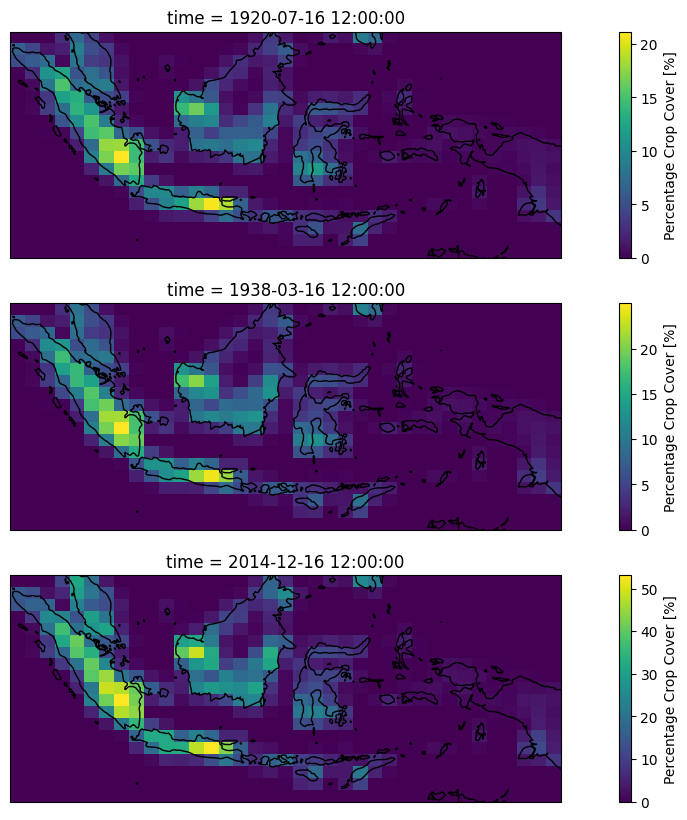

In [ ]:
fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
crop_ind_first.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=crop_ind_first.min().compute(),
    vmax=crop_ind_first.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=crop_ind_mid.min().compute(),
    vmax=crop_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=crop_ind_last.min().compute(),
    vmax=crop_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

In [ ]:
crop_frac = ds.treeFrac.sel(time=slice('1920-07-01','2023-07-01'), y=y_ind, x=x_ind)
crop_ind_last = crop_frac[-1,:,:].squeeze()
crop_ind_mid = crop_frac[212,:,:].squeeze()
crop_ind_first = crop_frac[0,:,:].squeeze()

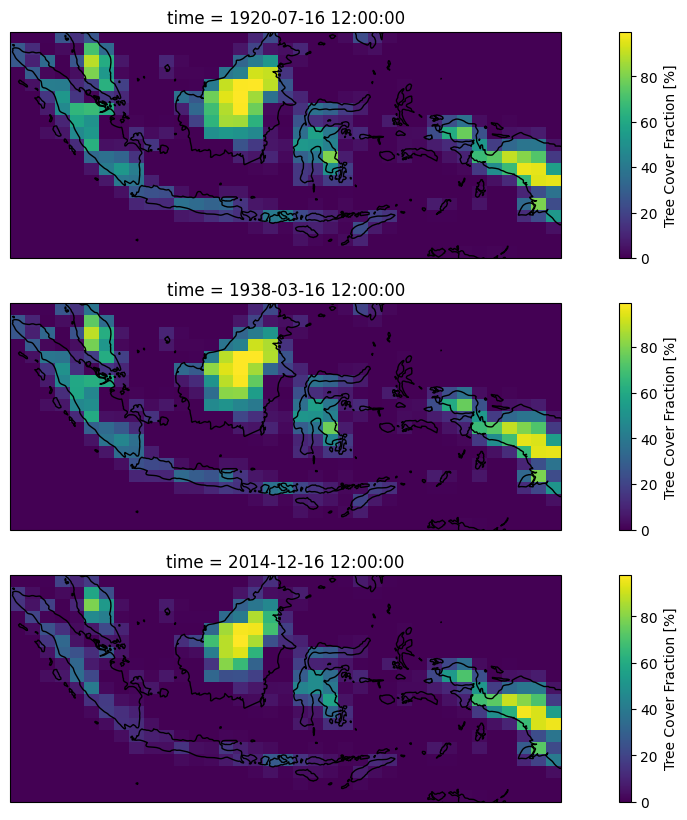

In [ ]:
fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
crop_ind_first.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=crop_ind_first.min().compute(),
    vmax=crop_ind_first.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=crop_ind_mid.min().compute(),
    vmax=crop_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=crop_ind_last.min().compute(),
    vmax=crop_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

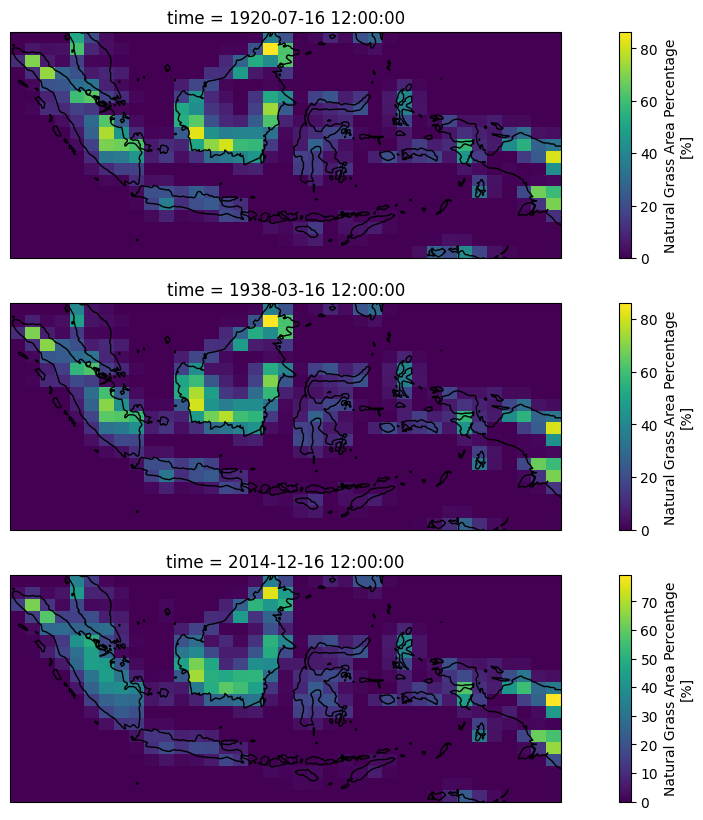

In [ ]:
crop_frac = ds.grassFrac.sel(time=slice('1920-07-01','2023-07-01'), y=y_ind, x=x_ind)
crop_ind_last = crop_frac[-1,:,:].squeeze()
crop_ind_mid = crop_frac[212,:,:].squeeze()
crop_ind_first = crop_frac[0,:,:].squeeze()

fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
crop_ind_first.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=crop_ind_first.min().compute(),
    vmax=crop_ind_first.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=crop_ind_mid.min().compute(),
    vmax=crop_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=crop_ind_last.min().compute(),
    vmax=crop_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

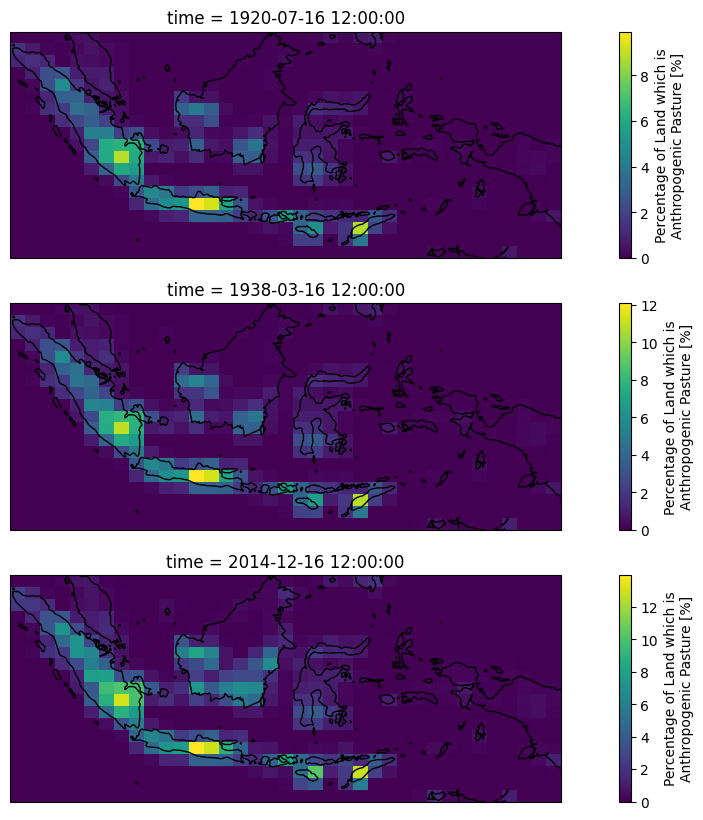

In [ ]:
crop_frac = ds.pastureFrac.sel(time=slice('1920-07-01','2023-07-01'), y=y_ind, x=x_ind)
crop_ind_last = crop_frac[-1,:,:].squeeze()
crop_ind_mid = crop_frac[212,:,:].squeeze()
crop_ind_first = crop_frac[0,:,:].squeeze()

fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
crop_ind_first.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=crop_ind_first.min().compute(),
    vmax=crop_ind_first.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=crop_ind_mid.min().compute(),
    vmax=crop_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=crop_ind_last.min().compute(),
    vmax=crop_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

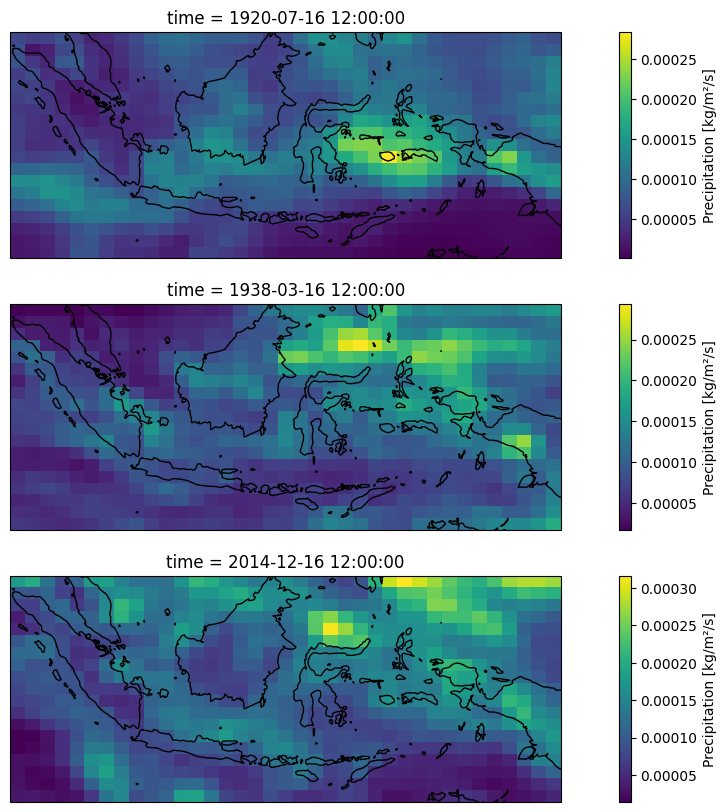

In [ ]:
crop_frac = ds.pr.sel(time=slice('1920-07-01','2023-07-01'), y=y_ind, x=x_ind)
crop_ind_last = crop_frac[-1,:,:].squeeze()
crop_ind_mid = crop_frac[212,:,:].squeeze()
crop_ind_first = crop_frac[0,:,:].squeeze()

fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
crop_ind_first.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=crop_ind_first.min().compute(),
    vmax=crop_ind_first.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=crop_ind_mid.min().compute(),
    vmax=crop_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=crop_ind_last.min().compute(),
    vmax=crop_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

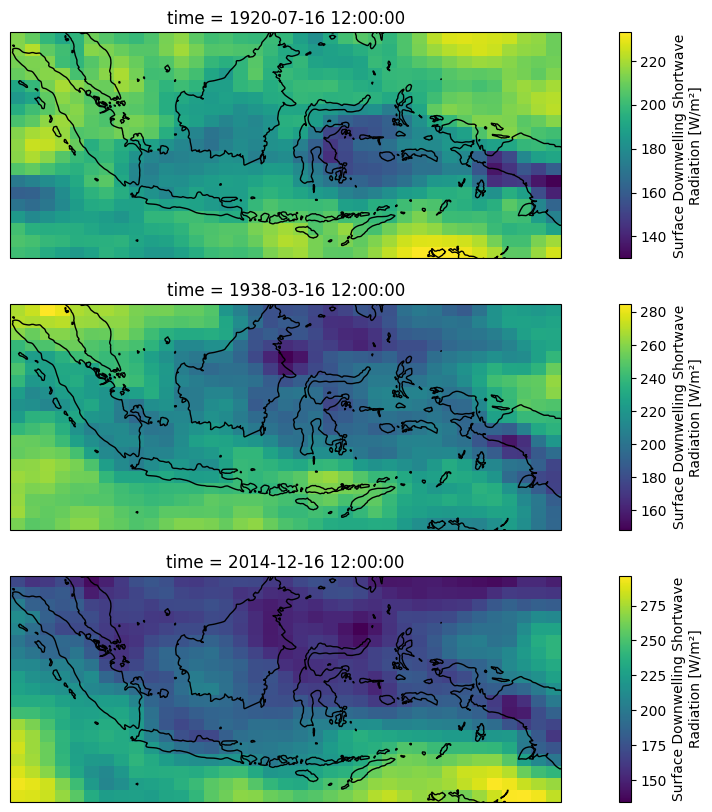

In [ ]:
crop_frac = ds.rsds.sel(time=slice('1920-07-01','2023-07-01'), y=y_ind, x=x_ind)
crop_ind_last = crop_frac[-1,:,:].squeeze()
crop_ind_mid = crop_frac[212,:,:].squeeze()
crop_ind_first = crop_frac[0,:,:].squeeze()

fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
crop_ind_first.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=crop_ind_first.min().compute(),
    vmax=crop_ind_first.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=crop_ind_mid.min().compute(),
    vmax=crop_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=crop_ind_last.min().compute(),
    vmax=crop_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

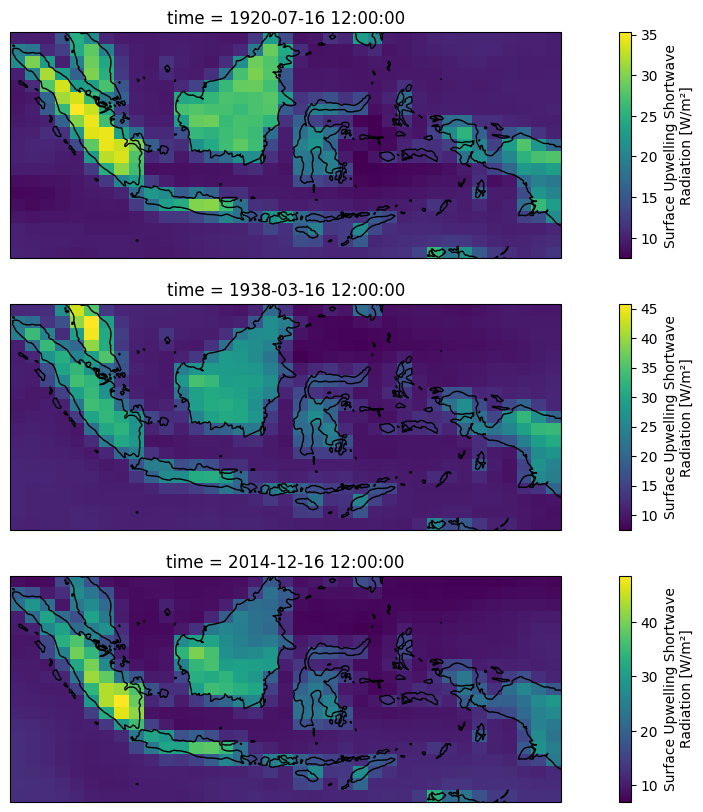

In [ ]:
crop_frac = ds.rsus.sel(time=slice('1920-07-01','2023-07-01'), y=y_ind, x=x_ind)
crop_ind_last = crop_frac[-1,:,:].squeeze()
crop_ind_mid = crop_frac[212,:,:].squeeze()
crop_ind_first = crop_frac[0,:,:].squeeze()

fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
crop_ind_first.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=crop_ind_first.min().compute(),
    vmax=crop_ind_first.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=crop_ind_mid.min().compute(),
    vmax=crop_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=crop_ind_last.min().compute(),
    vmax=crop_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

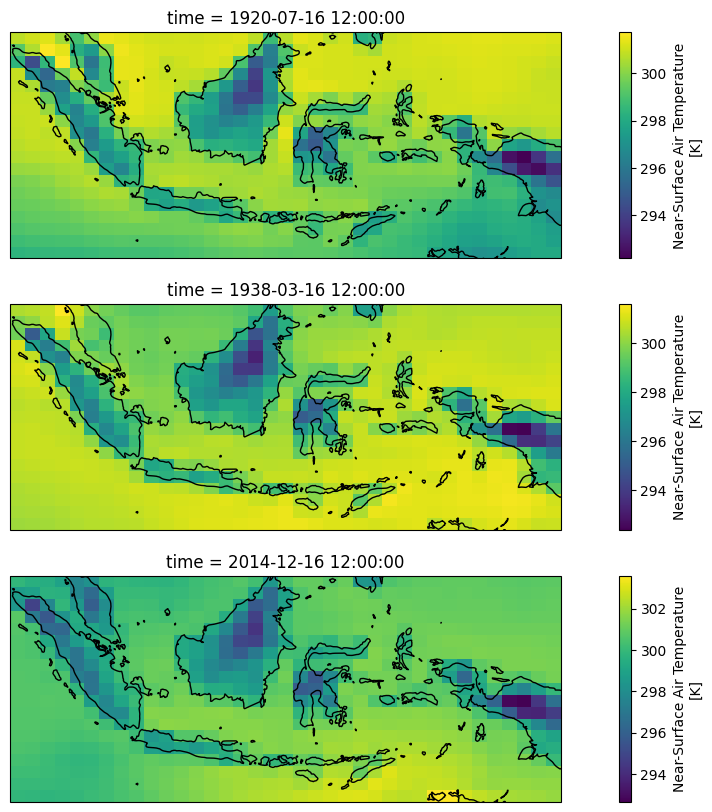

In [ ]:
crop_frac = ds.tas.sel(time=slice('1920-07-01','2023-07-01'), y=y_ind, x=x_ind)
crop_ind_last = crop_frac[-1,:,:].squeeze()
crop_ind_mid = crop_frac[212,:,:].squeeze()
crop_ind_first = crop_frac[0,:,:].squeeze()

fig, ax = plt.subplots(
    ncols=1, nrows=3, figsize=[15, 10], subplot_kw={"projection": ccrs.PlateCarree()}
)
# plot the model data
crop_ind_first.plot(
    ax=ax[0],
    x="lon",
    y="lat",
    vmin=crop_ind_first.min().compute(),
    vmax=crop_ind_first.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_mid.plot(
    ax=ax[1],
    x="lon",
    y="lat",
    vmin=crop_ind_mid.min().compute(),
    vmax=crop_ind_mid.max().compute(),
    cmap="viridis",
    robust=True # This deletes outliers: use 2nd and 98th percentiles of data
)

crop_ind_last.plot(
    ax=ax[2],
    x="lon",
    y="lat",
    vmin=crop_ind_last.min().compute(),
    vmax=crop_ind_last.max().compute(),
    cmap="viridis",
    robust=True
)
ax[0].coastlines()
#ax[0].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_first['time'].values, unit='D')}")

ax[1].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

ax[2].coastlines()
#ax[1].set_title(f"Indonesia Tree Cover - {np.datetime_as_string(ts_ind_last['time'].values, unit='D')}")

In [ ]:
## all variables for Indonesia

Indonesia = ds.sel(y=y_ind, x=x_ind)
#Indonesia

In [ ]:
type(Indonesia)

xarray.core.dataset.Dataset

In [ ]:
#df_Indonesia = Indonesia.to_dataframe()

In [ ]:
## Get the timeseries of the data so that I have the country mean of all variables along all time points
import pandas as pd

Indonesia_timeseries = ds.sel( y=y_ind, x=x_ind)
Indonesia_timeseries = Indonesia_timeseries.mean(['y','x'], keep_attrs=True)
type(Indonesia_timeseries)
Indonesia_timeseries_mean = Indonesia_timeseries.to_dataframe()
Indonesia_timeseries_mean.head(5)

,cropFrac,gpp,grassFrac,nbp,npp,pastureFrac,treeFrac,nep,pr,rsds,rsus,tas,areacella
time,,,,,,,,,,,,,
1850-01-16 12:00:00,0.655965,4.923347e-08,7.878640,-3.374646e-09,2.103969e-08,0.115874,12.365179,-2.800102e-09,0.000127,204.668854,13.699398,299.486267,1.536298e+10
1850-02-15 00:00:00,0.655965,5.173679e-08,7.948023,1.254644e-09,2.432578e-08,0.115874,12.368155,1.938519e-09,0.000120,206.916077,13.525014,299.328125,1.536298e+10
1850-03-16 12:00:00,0.655965,5.405060e-08,8.028105,3.827634e-09,2.587070e-08,0.115874,12.369579,4.487883e-09,0.000123,208.666824,13.711241,299.337067,1.536298e+10
1850-04-16 00:00:00,0.655965,5.238121e-08,8.111268,2.724934e-09,2.393364e-08,0.115874,12.373181,3.417906e-09,0.000116,209.314056,13.727771,299.734192,1.536298e+10
1850-05-16 12:00:00,0.655965,5.258140e-08,8.176950,1.705504e-09,2.430349e-08,0.115874,12.378870,2.285713e-09,0.000078,211.948837,14.260653,299.648163,1.536298e+10


In [ ]:
Indonesia_timeseries_mean.shape

(1980, 13)

In [ ]:
Indonesia_timeseries_mean.to_csv('Indonesia_timeseries_mean.csv', index=True)

# Covariance and correlation analysis

In [ ]:
# crops
# crop_frac
# rain
# rain = do_pr.precip.sel(time=slice('1979-01-01','2014-12-16'), lat=y_ind, lon=x_ind)
# sst
# sst = do_sst.sst.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)
# air temp anom
# tas = do_tas.air.sel(time=slice('1979-01-01','2023-07-01'), lat=y_ind, lon=x_ind)

In [ ]:
# take the timeseries
## Coordinates Indonesia

x_ind = slice(95, 141) # longitude
y_ind = slice(7,-12) # latitude

## SST

sst_timeseries = do_sst.sel(time=slice('1979-07-01','2014-12-01'), lat=y_ind, lon=x_ind)
sst_timeseries = sst_timeseries.mean(["lon", "lat"], keep_attrs=True)
sst_timeseries_mean = np.array(sst_timeseries.sst)

## Air temp anomalies

tas_timeseries = do_tas.sel(time=slice('1979-07-01','2014-12-01'), lat=y_ind, lon=x_ind)
tas_timeseries = tas_timeseries.mean(["lon", "lat"], keep_attrs=True)
tas_timeseries_mean = np.array(tas_timeseries.air)

## Precipitation

rain_timeseries = do_pr.sel(time=slice('1979-07-01','2014-12-01'), lat=y_ind, lon=x_ind)
rain_timeseries = rain_timeseries.mean(["lon", "lat"], keep_attrs=True)
rain_timeseries_mean = np.array(rain_timeseries.precip)

In [ ]:
## Crop fraction

x_ind = slice(95, 141) # longitude
y_ind = slice(-12,7) # latitude

crop_frac_timeseries = ds.sel(time=slice('1979-07-01','2014-12-16'), y=y_ind, x=x_ind)
crop_frac_timeseries = crop_frac_timeseries.mean(['y','x'], keep_attrs=True)
crop_frac_timeseries_mean = np.array(crop_frac_timeseries.cropFrac)

In [ ]:
var = [rain_timeseries_mean, tas_timeseries_mean, sst_timeseries_mean]

In [ ]:
print(len(tas_timeseries_mean))
print(len(crop_frac_timeseries_mean))
print(len(rain_timeseries_mean))
print(len(sst_timeseries_mean))


426
426
426
426


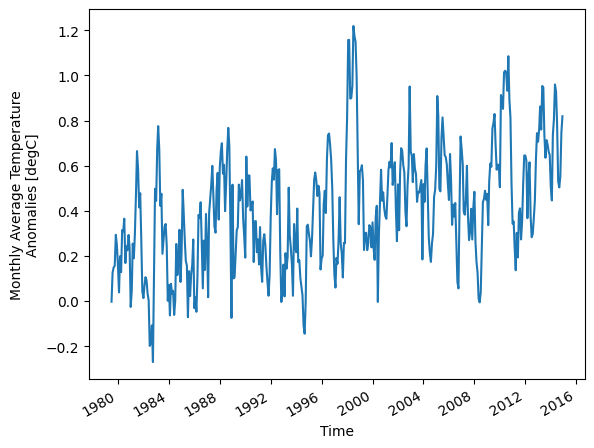

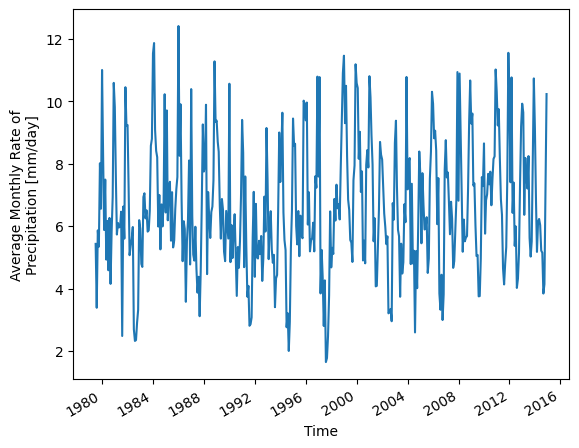

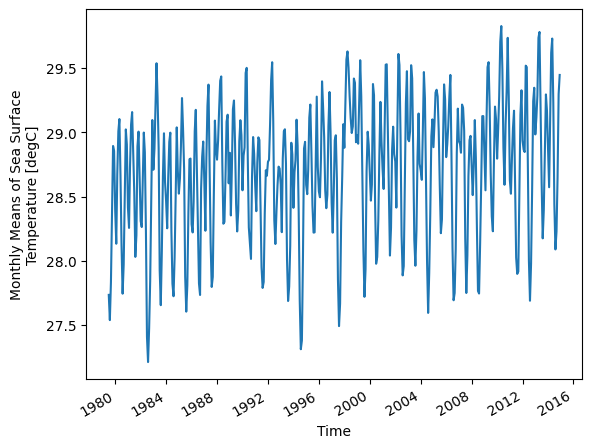

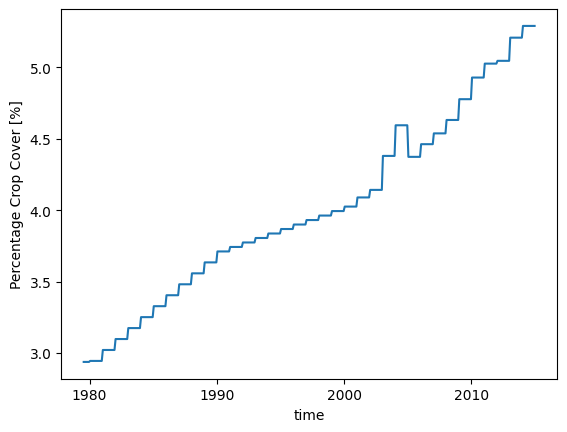

In [ ]:
## Plots


tas_timeseries.air.plot()
plt.show();
print()

rain_timeseries.precip.plot()
plt.show();
print()

sst_timeseries.sst.plot()
plt.show();
print()

crop_frac_timeseries.cropFrac.plot()
plt.show();


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


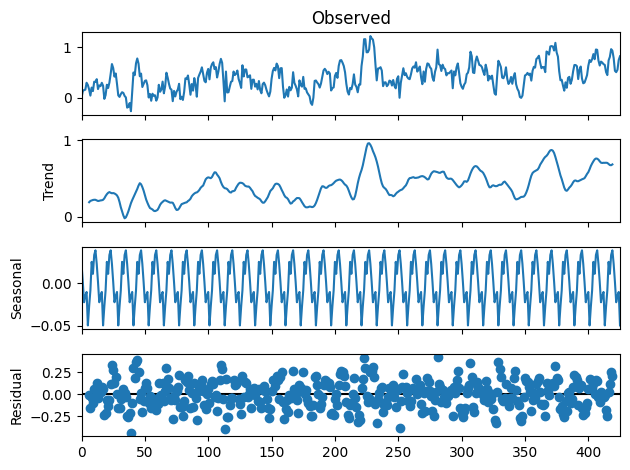

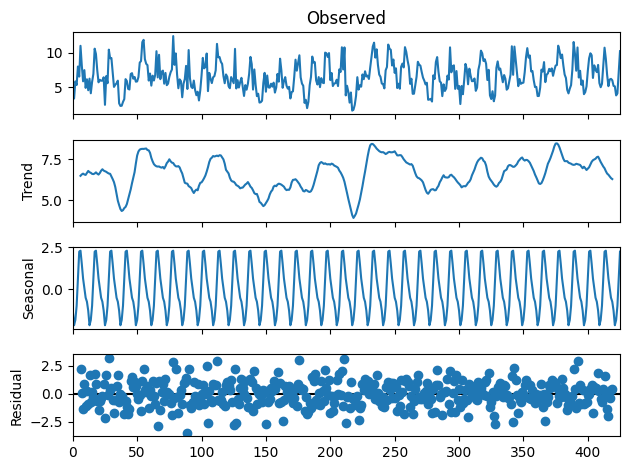

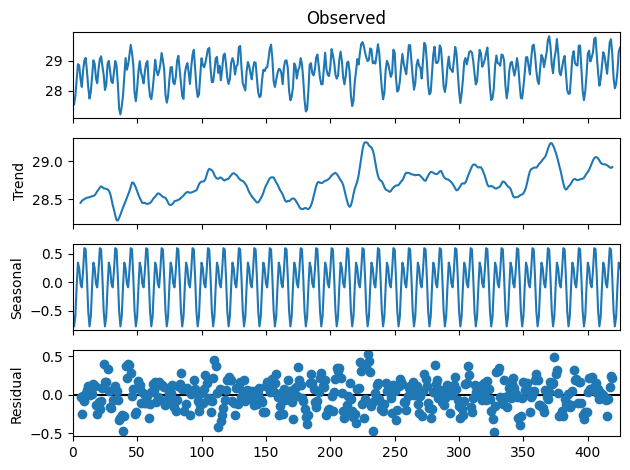

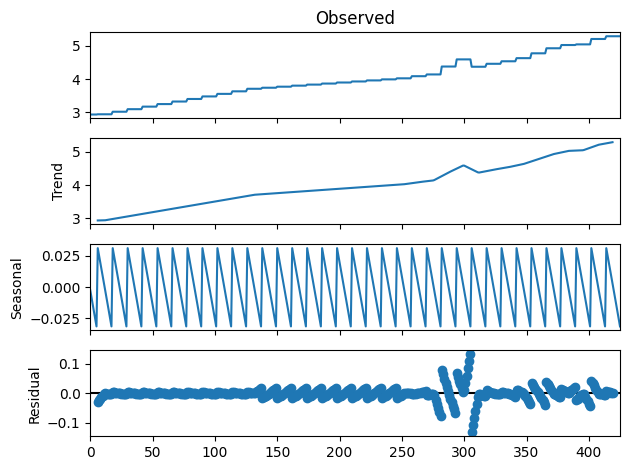

In [ ]:
# Decomposition

result = seasonal_decompose(tas_timeseries_mean, model='additive', period=12)
result.plot();

result = seasonal_decompose(rain_timeseries_mean, model='additive', period=12)
result.plot();

result = seasonal_decompose(sst_timeseries_mean, model='additive', period=12)
result.plot();

result = seasonal_decompose(crop_frac_timeseries_mean, model='additive', period=12)
result.plot();

In [ ]:
names = ['rain','tas', 'sst']

## Covariance

for i,n in zip(var, names):
    print(n)
    print(np.cov(i, crop_frac_timeseries_mean))
    print()

rain
[[4.35749255 0.12502138]
 [0.12502138 0.41552499]]

tas
[[0.06944209 0.08144058]
 [0.08144058 0.41552499]]

sst
[[0.26761744 0.0800254 ]
 [0.0800254  0.41552499]]



In [ ]:
## Correlation

# Pearson for linear correlation

from scipy.stats import pearsonr

for i,n in zip(var, names):
    print(n)
    print(round(pearsonr(i, crop_frac_timeseries_mean)[1],5))
    print()

rain
0.05534

tas
0.0

sst
0.0



In [ ]:
# Spearman for nonlinear correlation
# If  you are unsure of the distribution and possible relationships between two variables, Spearman correlation coefficient is a good tool to use.
from scipy.stats import spearmanr

for i,n in zip(var, names):
    print(n)
    print(round(spearmanr(i, crop_frac_timeseries_mean)[1],5))
    print()

rain
0.04489

tas
0.0

sst
0.0



# Stationarity test

In [ ]:
# print(len(tas_timeseries_mean))
# print(len(crop_frac_timeseries_mean))
# print(len(rain_timeseries_mean))
# print(len(sst_timeseries_mean))


In [ ]:
plt.hist(tas_timeseries_mean);
stats.describe(tas_timeseries_mean)

In [ ]:
plt.hist(crop_frac_timeseries_mean);
stats.describe(crop_frac_timeseries_mean)

In [ ]:
plt.hist(rain_timeseries_mean);
stats.describe(rain_timeseries_mean)


In [ ]:
plt.hist(sst_timeseries_mean);
stats.describe(sst_timeseries_mean)


In [ ]:
values = [sst_timeseries_mean, rain_timeseries_mean, tas_timeseries_mean, crop_frac_timeseries_mean]
names = ['sst', 'rain', 'tas', 'crop']

In [ ]:
## ADF

from statsmodels.tsa.stattools import adfuller

for value, key in zip(values, names):
  print(key)
  result = adfuller(value)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

sst
ADF Statistic: -4.912356
p-value: 0.000033
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571
rain
ADF Statistic: -5.935715
p-value: 0.000000
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571
tas
ADF Statistic: -6.380141
p-value: 0.000000
Critical Values:
	1%: -3.446
	5%: -2.868
	10%: -2.570
crop
ADF Statistic: 0.246514
p-value: 0.974753
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571


In [ ]:
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings("ignore")


for value, key in zip(values, names):
  print(key)
  result = kpss(value)
  print('KPSS Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print()

sst
KPSS Statistic: 1.138680
p-value: 0.010000

rain
KPSS Statistic: 0.233681
p-value: 0.100000

tas
KPSS Statistic: 1.565564
p-value: 0.010000

crop
KPSS Statistic: 3.241789
p-value: 0.010000



In [ ]:
## It looks like our crop variable is trend stationary

In [ ]:
# pip install arch

In [ ]:
import arch
from arch.unitroot import PhillipsPerron as pp

for value, key in zip(values, names):
  print(key)
  result = pp(value)
  print('PP Statistic: %f' % result.stat)
  print('p-value: %f' % result.pvalue)
  print()

sst
PP Statistic: -7.078524
p-value: 0.000000

rain
PP Statistic: -9.660850
p-value: 0.000000

tas
PP Statistic: -6.305022
p-value: 0.000000

crop
PP Statistic: 0.512777
p-value: 0.985256



In [ ]:
for value, key in zip(values, names):
  print(key)
  result = pp(value, trend='ct')
  print('PP Statistic: %f' % result.stat)
  print('p-value: %f' % result.pvalue)
  print()

sst
PP Statistic: -6.903401
p-value: 0.000000

rain
PP Statistic: -9.610017
p-value: 0.000000

tas
PP Statistic: -6.852246
p-value: 0.000000

crop
PP Statistic: -2.150957
p-value: 0.517471



### Stationarity test with first difference

In [ ]:
# Take the first difference

In [ ]:
## Plots


plt.plot(np.diff(tas_timeseries.air))
plt.show();
print()


plt.plot(np.diff(rain_timeseries.precip))
plt.show();
print()

plt.plot(np.diff(sst_timeseries.sst))
plt.show();
print()

plt.plot(np.diff(crop_frac_timeseries.cropFrac))
plt.show();


In [ ]:
values = [np.diff(sst_timeseries_mean), np.diff(rain_timeseries_mean), np.diff(tas_timeseries_mean), np.diff(crop_frac_timeseries_mean)]
names = ['sst', 'rain', 'tas', 'crop']

In [ ]:
## ADF

for value, key in zip(values, names):
  print(key)
  result = adfuller(value)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
for value, key in zip(values, names):
  print(key)
  result = kpss(value)
  print('KPSS Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print()

In [ ]:
for value, key in zip(values, names):
  print(key)
  result = pp(value)
  print('PP Statistic: %f' % result.stat)
  print('p-value: %f' % result.pvalue)
  print()

In [ ]:
for value, key in zip(values, names):
  print(key)
  result = pp(value, trend='ct')
  print('PP Statistic: %f' % result.stat)
  print('p-value: %f' % result.pvalue)
  print()

In [ ]:
## Staionarity test considering all years of the time series

# take the timeseries
## Coordinates Indonesia

x_ind = slice(95, 141) # longitude
y_ind = slice(7,-12) # latitude

## SST

sst_timeseries = do_sst.sel(lat=y_ind, lon=x_ind)
sst_timeseries = sst_timeseries.mean(["lon", "lat"], keep_attrs=True)
sst_timeseries_mean = np.array(sst_timeseries.sst)

## Air temp anomalies

tas_timeseries = do_tas.sel(lat=y_ind, lon=x_ind)
tas_timeseries = tas_timeseries.mean(["lon", "lat"], keep_attrs=True)
tas_timeseries_mean = np.array(tas_timeseries.air)

## Precipitation

rain_timeseries = do_pr.sel(lat=y_ind, lon=x_ind)
rain_timeseries = rain_timeseries.mean(["lon", "lat"], keep_attrs=True)
rain_timeseries_mean = np.array(rain_timeseries.precip)

In [ ]:
values = [sst_timeseries_mean, rain_timeseries_mean, tas_timeseries_mean, crop_frac_timeseries_mean]
names = ['sst', 'rain', 'tas', 'crop']

In [ ]:
## ADF

from statsmodels.tsa.stattools import adfuller

for value, key in zip(values, names):
  print(key)
  result = adfuller(value)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

sst
ADF Statistic: -3.671502
p-value: 0.004532
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
rain
ADF Statistic: -6.437928
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570
tas
ADF Statistic: -3.346394
p-value: 0.012928
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568
crop
ADF Statistic: 0.246514
p-value: 0.974753
Critical Values:
	1%: -3.446
	5%: -2.869
	10%: -2.571


In [ ]:
from statsmodels.tsa.stattools import kpss
import warnings
warnings.filterwarnings("ignore")


for value, key in zip(values, names):
  print(key)
  result = kpss(value)
  print('KPSS Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print()

sst
KPSS Statistic: 3.431955
p-value: 0.010000

rain
KPSS Statistic: 0.296821
p-value: 0.100000

tas
KPSS Statistic: 4.091714
p-value: 0.010000

crop
KPSS Statistic: 3.241789
p-value: 0.010000



In [ ]:
## Nothing really changed

In [ ]:
# Let' s try detrending the crop variable and see if the results change
from scipy.signal import detrend
import pandas as pd

detrended = detrend(crop_frac_timeseries_mean, type='linear')
detrended = pd.Series(detrended)

In [ ]:
## ADF


result = adfuller(detrended)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print(f'Critical Values: {result}')


ADF Statistic: -1.998232
p-value: 0.287349
Critical Values: (-1.9982323024025928, 0.2873487104452982, 12, 413, {'1%': -3.4462831955497135, '5%': -2.8685636962704395, '10%': -2.5705114078759914}, -1820.366629962104)


# Plot CMIP6 data